# <center> Simple multi-classification </center>

## Imports

In [1]:
%matplotlib inline

import theano
import theano.tensor as T
import theano.tensor.nnet as nnet
import numpy
import matplotlib.pyplot as plt

rng = numpy.random # random number generator

## Settings & Functions

In [2]:
### SETTINGS ###

nTrainSamples = 1000 # number of learning samples
nTrainSteps   = 100  # number of training steps
alpha = 0.25         # learning rate
nTestSamples = 1000  # number of testing samples

xSeg = 3 # number of x segments
ySeg = 2 # number of y segments

nClasses = xSeg * ySeg

xSegWidth = 1.0 / xSeg # the width of x segment
ySegWidth = 1.0 / ySeg # the width of y segment

### FUNCTIONS ####

def getClass (x): # return class id
    xId = int(x[0] / xSegWidth)
    yId = int(x[1] / ySegWidth)
    return xSeg * yId + xId

def XtoY (x): # e.g class 2 = [0,0,1,0,0,...,0]
    y = [0] * nClasses
    y[getClass (x)] = 1
    return y

## Training samples

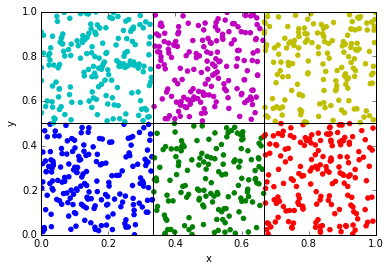

In [ ]:
### GENERATE TRAINING SAMPLES ###

X = (rng.sample((nTrainSamples, 2))) # random X in [0,1]x[0,1]
Y = [XtoY(x) for x in X]             # expected class id

### PLOT TRAINING SAMPLES ###

# 6 different colors, use the same if nClasses > 6
colors = ['b', 'g', 'r', 'c', 'm', 'y'] * (nClasses / 6 + 1)

# axis settings

plt.xlabel('x')
plt.ylabel('y')

plt.xlim([0,1])
plt.ylim([0,1])

# draw segments borders

for i in range(xSeg):
    plt.plot ([(i + 1) * xSegWidth] * 2, [0, 1], color = 'k')

for i in range(ySeg):
    plt.plot ([0,1], [(i + 1) * ySegWidth] * 2, color = 'k')

for i in range(nClasses):
    points = []
    for j in range(nTrainSamples):
        if getClass(X[j]) == i: points.append(X[j])
    plt.scatter (*zip(*points), color = colors[i])

## Learn NN

In [ ]:
###### SYMBOLIC VARIABLES ###

x = T.vector('x') # input (vector to extend by bias)
y = T.vector('y') # expected value

w1 = theano.shared(rng.rand(3,nClasses), name = 'w1')             # first hidden layer's weights (including bias)
w2 = theano.shared(rng.rand(nClasses + 1, nClasses), name = 'w2') # second hidden layer's weights (including bias)
w3 = theano.shared(rng.rand(nClasses + 1, nClasses), name = 'w3') # output layer's weights (including bias)

### EXPRESSION GRAPH ###

def layer (x, w):
    b = numpy.array([1])      # bias term
    xb = T.concatenate([x,b]) # input x with bias added
    return nnet.sigmoid(T.dot(w.T,xb))

hiddenLayer1 = layer(x, w1)            # hidden layer 1
hiddenLayer2 = layer(hiddenLayer1, w2) # hidden layer 2
outputLayer  = layer(hiddenLayer2, w3) # output layer

cost = T.sum(T.pow(outputLayer - y, 2)) # cost function

def gradient (c, w):                 # cost function, weights
    return w - alpha * T.grad (c, w) # update weights

### COMPILE ###

train = theano.function(inputs = [x,y],
                        outputs = cost,
                        updates = [(w1, gradient(cost, w1)),
                                   (w2, gradient(cost, w2)),
                                   (w3, gradient(cost, w3))])
                        
predict = theano.function(inputs=[x], outputs=outputLayer)

### TRAIN ###

for i in range (nTrainSteps):
    for j in range(nTrainSamples):
        c = train(X[j], Y[j]) 

## Test

In [ ]:
score = 0 # final score
good = [] # correctly reconstructed points
bad = []  # not correctly ...

for i in range(nTestSamples):           # generate nTestSamples testing points
    t = rng.sample(2)                   # random point
    p = predict(t).tolist()             # prediction [prob c1, prob c2, ...]
    if p.index(max(p)) == getClass (t): # prediction = max prob
        score += 1                      # good prediction
        good.append(t)                  
    else: bad.append(t)                 # bad prediction
                
print '\nScore =', 1.0 * score / nTestSamples

## Plot results

In [ ]:
# plot testing sample (black points are not reconstructed)

# 6 different colors, use the same if nClasses > 6
colors = ['b', 'g', 'r', 'c', 'm', 'y'] * (nClasses / 6 + 1)

# axis settings

plt.xlabel('x')
plt.ylabel('y')

plt.xlim([0,1])
plt.ylim([0,1])

# draw segments borders

for i in range(xSeg):
    plt.plot ([(i + 1) * xSegWidth] * 2, [0, 1], color = 'k')

for i in range(ySeg):
    plt.plot ([0,1], [(i + 1) * ySegWidth] * 2, color = 'k')

plt.text(1.2, 0.5, 'Black points are misclassified', fontsize = 15)
plt.scatter(*zip(*bad), color = 'k')
    
for i in range(nClasses):
    points = []
    for j in range(len(good)):
        if getClass(good[j]) == i: points.append(good[j])
    plt.scatter (*zip(*points), color = colors[i])